In [1]:
import os
import torch
from torch.utils.data import DataLoader
from utils.temp_utils import *
from utils.chexpert_dataset import CheXpertDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

CSV_PATH = "Datasets/CheXpertPlus/df_chexpert_plus_240401.csv"
IMG_ROOT = "Datasets/CheXpertPlus/PNG"

TEXT_COL = "section_impression"
PATH_COL = "path_to_image"

IMG_SIZE = 512
MAX_LEN = 64
NUM_BATCH = 4

tf = dino_image_transform(img_size=IMG_SIZE)

ds_train = CheXpertDataset(img_root=IMG_ROOT, csv_path=CSV_PATH, split="train", transform=tf, text_col=TEXT_COL)
ds_valid = CheXpertDataset(img_root=IMG_ROOT, csv_path=CSV_PATH, split="valid", transform=tf, text_col=TEXT_COL)
ds_test = CheXpertDataset(img_root=IMG_ROOT, csv_path=CSV_PATH, split="test", transform=tf, text_col=TEXT_COL)

tok = build_tokenizer_from_labels(gpt2=True)
pad_id = tok.pad_token_id
eos_id = tok.eos_token_id
bos_id = tok.bos_token_id
collate_fn = CaptionCollate(tok, pad_id)

train_loader = DataLoader(ds_train, batch_size=NUM_BATCH, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(ds_valid, batch_size=NUM_BATCH, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(ds_test, batch_size=NUM_BATCH, shuffle=False, collate_fn=collate_fn)

Using device: cuda
[INFO] Kept 95718/223462 rows with existing PNGs
[INFO] Kept 95718/223462 rows with existing PNGs
[INFO] Kept 95718/223462 rows with existing PNGs
Using GPT2 tokenizer.


In [3]:
batch = next(iter(train_loader))

In [4]:
batch[0][0].shape

torch.Size([3, 512, 512])

In [5]:
import torch
import torch.nn as nn

import numpy as np
import torch.nn.functional as F
from transformers import AutoModel

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "Datasets\CheXpertPlus\dino_unet_decoder_finetuned.pth"

class DinoUNet(nn.Module):
    def __init__(self, model_name="facebook/dinov3-convnext-small-pretrain-lvd1689m"):
        super().__init__()
        print("Cargando encoder DINOv3...")
        self.encoder = AutoModel.from_pretrained(model_name).to(DEVICE)
        self.channel_adapter = nn.Conv2d(768, 512, kernel_size=1)
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
            nn.Conv2d(64, 1, 1)
        )

    def forward(self, x):
        enc_feats = self.encoder(x, output_hidden_states=True, return_dict=True)
        feats = next(h for h in reversed(enc_feats.hidden_states) if isinstance(h, torch.Tensor) and h.ndim == 4)
        feats = self.channel_adapter(feats)
        return self.decoder(feats)

class DINOEncoder(nn.Module):
    def __init__(self, model_id="facebook/dinov3-vits16-pretrain-lvd1689m", freeze=True):
        super().__init__()
        from transformers import AutoModel
        self.model = AutoModel.from_pretrained(model_id)
        if freeze:
            for p in self.model.parameters():
                p.requires_grad = False

    @torch.no_grad()
    def forward(self, pixel_values):
        out = self.model(pixel_values=pixel_values)
        tokens = out.last_hidden_state
        cls = tokens[:, 0, :]
        patches = tokens[:, 5:, :]
        return cls, patches

encoder = DINOEncoder().to("cpu")
encoder.eval()

segmentator = DinoUNet().to("cpu")
segmentator.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
segmentator.eval()

from utils.modifiedGPT2 import create_decoder
decoder = create_decoder().to(DEVICE)

vis_dim = 384
linear_projection = nn.Linear(vis_dim, decoder.config.n_embd).to(DEVICE)

# -*- coding: utf-8 -*-
import os
import math
import numpy as np
from PIL import Image

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def normalize01_torch(x: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """
    Normaliza por muestra a [0,1].
    Acepta: (B, H, W) o (B, 1, H, W)
    Devuelve: (B, 1, H, W)
    """
    if x.ndim == 3:        # (B,H,W) -> (B,1,H,W)
        x = x.unsqueeze(1)
    xmin = x.amin(dim=(2,3), keepdim=True)
    xmax = x.amax(dim=(2,3), keepdim=True)
    denom = (xmax - xmin).clamp_min(eps)
    y = (x - xmin) / denom
    # Asegurar 1 canal
    if y.shape[1] != 1:
        y = y[:, :1]
    return y

def _ensure_odd(k: int) -> int:
    k = max(int(k), 1)
    return k if (k % 2 == 1) else (k + 1)

def gaussian_kernel1d_torch(ksize: int, sigma: float | None = None, device=None, dtype=None) -> torch.Tensor:
    """
    1D Gaussian kernel normalizado (suma 1), tamaño impar.
    """
    k = _ensure_odd(ksize)
    if sigma is None or sigma <= 0:
        sigma = (k - 1) / 6.0
    r = k // 2
    x = torch.arange(-r, r + 1, device=device, dtype=torch.float32 if dtype is None else dtype)
    g = torch.exp(-(x**2) / (2.0 * sigma * sigma))
    g = g / g.sum()
    return g  # (k,)

def gaussian_blur2d_with_ksize_torch(x: torch.Tensor, ksize: int, sigma: float | None = None) -> torch.Tensor:
    """
    Desenfoque gaussiano separable 2D con padding reflect.
    x: (B,1,H,W)
    return: (B,1,H,W)
    """
    B, C, H, W = x.shape
    assert C == 1, "Se espera 1 canal"
    device, dtype = x.device, x.dtype

    k1 = gaussian_kernel1d_torch(ksize, sigma, device=device, dtype=dtype)  # (K,)
    pad = k1.numel() // 2

    # Conv horizontal (1xK)
    xh = F.pad(x, (pad, pad, 0, 0), mode="reflect")
    weight_h = k1.view(1, 1, 1, -1)                                        # (outC,inC,1,K)
    xh = F.conv2d(xh, weight_h)

    # Conv vertical (Kx1)
    xv = F.pad(xh, (0, 0, pad, pad), mode="reflect")
    weight_v = k1.view(1, 1, -1, 1)                                        # (outC,inC,K,1)
    out = F.conv2d(xv, weight_v)
    return out

def resize_to_32(x: torch.Tensor) -> torch.Tensor:
    """
    x: (B, H, W) -> (B, 32, 32)
    """
    if x.ndim != 3:
        raise ValueError(f"Expected (B,H,W), got {tuple(x.shape)}")
    x = x.float().unsqueeze(1)  # (B,1,H,W)
    x = F.interpolate(x, size=(32, 32), mode="bilinear", align_corners=False)
    return x.squeeze(1)         # (B,32,32)

def apply_filter(x32: torch.Tensor,
                 layer_idx: int,
                 base_ksize: int = 3,
                 ksize_growth: int = 2,
                 sigma: float | None = None) -> torch.Tensor:
    """
    x32: (B,32,32)
    Normaliza a [0,1], aplica blur gaussiano con ksize creciente por capa y regresa (B,32,32).
    """
    x_norm = normalize01_torch(x32).to(x32.dtype)   # (B,1,32,32)
    ksize = _ensure_odd(base_ksize + layer_idx * ksize_growth)
    y = gaussian_blur2d_with_ksize_torch(x_norm, ksize=ksize, sigma=sigma)  # (B,1,32,32)
    y = normalize01_torch(y).squeeze(1)                                     # (B,32,32)
    return y

def build_layer_stack(x32: torch.Tensor, n_layers: int,
                      base_ksize: int = 3, ksize_growth: int = 2, sigma: float | None = None) -> torch.Tensor:
    """
    Aplica apply_filter() n_layers veces y apila:
    Entrada:  x32 (B,32,32)
    Salida:   (B, n_layers, 32, 32)
    """
    layers = []
    for i in range(n_layers, 0, -1):  # capas n_layers ... 1
        y = apply_filter(x32, layer_idx=i, base_ksize=base_ksize, ksize_growth=ksize_growth, sigma=sigma)  # (B,32,32)
        layers.append(y.unsqueeze(1))  # (B,1,32,32)
    return torch.cat(layers, dim=1)    # (B,n_layers,32,32)

def flatten_and_tile(x_layers: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    """
    x_layers: (B, n_layers, 32, 32)
      -> flat:  (B, n_layers, 1024)
      -> tiled: (B, n_layers, 1024, 1024)  (repitiendo valores a lo largo de la última nueva dimensión)
    """
    B, L, H, W = x_layers.shape
    if (H, W) != (32, 32):
        raise ValueError("Expected spatial size 32x32 before flatten.")
    flat = x_layers.reshape(B, L, H * W)                  # (B,L,1024)
    tiled = flat.unsqueeze(-2).expand(-1, -1, H * W, -1)   # (B,L,1024,1024) tile[0,0,:,j] = flat[0,0,:] for all j
    return flat, tiled

def pipeline(x: torch.Tensor, n_layers: int,
             base_ksize: int = 3, ksize_growth: int = 2, sigma: float | None = None):
    """
    x: (B,H,W)  [cualquier HxW]
    Retorna:
      - stacked: (B, n_layers, 32, 32)
      - flat:    (B, n_layers, 1024)
      - tiled:   (B, n_layers, 1024, 1024)
    """
    x32 = resize_to_32(x)                                                # (B,32,32)
    stacked = build_layer_stack(x32, n_layers, base_ksize, ksize_growth, sigma)  # (B,n_layers,32,32)
    flat, tiled = flatten_and_tile(stacked)
    return stacked, flat, tiled

def plot_stacked_layers(stacked: torch.Tensor, sample_idx: int = 0, cols: int = 6, save_path: str | None = None):
    """
    Muestra en gris cada capa de stacked[sample_idx] en una grilla.
    stacked: (B, n_layers, 32, 32)
    sample_idx: índice del batch a mostrar (default 0)
    cols: columnas de la grilla
    save_path: si no es None, guarda la figura en esa ruta
    """
    if stacked.ndim != 4:
        raise ValueError(f"Expected (B, n_layers, H, W), got {tuple(stacked.shape)}")

    B, L, H, W = stacked.shape
    if sample_idx < 0 or sample_idx >= B:
        raise IndexError(f"sample_idx out of range: {sample_idx} (B={B})")

    imgs = stacked[sample_idx].detach().cpu().numpy().astype(np.float32)  # (L,H,W)

    # Normaliza cada capa a [0,1] individualmente
    mn = imgs.min(axis=(1, 2), keepdims=True)
    mx = imgs.max(axis=(1, 2), keepdims=True)
    denom = np.where((mx - mn) < 1e-8, 1.0, (mx - mn))
    imgs_norm = (imgs - mn) / denom  # (L,H,W) en [0,1]

    rows = math.ceil(L / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))
    axes = np.atleast_2d(axes).reshape(rows, cols)

    for i in range(rows * cols):
        ax = axes[i // cols, i % cols]
        ax.axis('off')
        if i < L:
            ax.imshow(imgs_norm[i], cmap='gray', vmin=0.0, vmax=1.0)
            ax.set_title(f"Layer {i}", fontsize=8)
        else:
            ax.imshow(np.zeros((H, W), dtype=np.float32), cmap='gray', vmin=0.0, vmax=1.0)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    return fig

def denormalize(image_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(image_tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(image_tensor.device)
    image_tensor = image_tensor * std + mean
    image_tensor = torch.clamp(image_tensor, 0, 1)
    image_tensor = (image_tensor * 255).byte()
    return image_tensor

from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# with torch.no_grad():
#     pixel_values, tgt_ids, paths, raw_labels = next(iter(train_loader))
#     pixel_values = pixel_values.to(DEVICE)

#     pred = segmentator(pixel_values)
#     pred = F.interpolate(pred, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False)
#     pred_sig = torch.sigmoid(pred).cpu().numpy()
#     masks = (pred_sig[:, 0] > 0.5).astype(np.uint8) * 255
#     B = masks.shape[0]
#     n_layers = decoder.config.num_hidden_layers
#     BASE_KSIZE = 3
#     KSIZE_GROW = 4
#     SIGMA = None  # heurística

#     stacked, flat, tiled = pipeline(torch.tensor(masks), n_layers, BASE_KSIZE, KSIZE_GROW, SIGMA)
#     print("stacked:", stacked.shape)  # (B,12,32,32)
#     print("flat:   ", flat.shape)     # (B,12,1024)
#     print("tiled:  ", tiled.shape)    # (B,12,1024,1024)

#     _, patches = encoder(pixel_values)
    
#     patches = linear_projection(patches)
    
#     # logits = decoder(inputs_embeds=patches, segmentation_mask=tiled.to(DEVICE))

#     gen_ids = decoder.generate(inputs_embeds=patches,
#                          max_new_tokens=100,
#                          do_sample=False,           # False -> greedy / beams 
#                          repetition_penalty=1.2,
#                          eos_token_id=tokenizer.eos_token_id,
#                          pad_token_id=tokenizer.pad_token_id,
#                          segmentation_mask=tiled.to(DEVICE),
#                          prefix_allowed_length=0,
#                          plot_attention_mask=False,
#                          plot_attention_mask_layer=[0, 6],
#                          plot_attention_map=True,
#                          plot_attention_map_layer=[0, 6],
#                          plot_attention_map_generation=0)
    
#     text = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)

#     for b in range(B):
#         print(f"Example {b} out of {B} in Batch")
#         plt.figure(figsize=(4, 2))
#         plt.subplot(1, 2, 1)
#         plt.title("Input Image")
#         plt.imshow(denormalize(pixel_values[b]).permute(1, 2, 0).cpu().numpy().astype(np.uint8))
#         plt.axis("off")

#         plt.subplot(1, 2, 2)
#         plt.title("Predicted Mask")
#         plt.imshow(masks[b], cmap="gray")
#         plt.axis("off")
#         plt.show()

#         print("Segmentation mask per layer")
#         plot_stacked_layers(stacked, sample_idx=b, cols=6)
#         plt.show()

#         print("Generated text:",text[b])

#         print("Original Impression Text:", raw_labels[b])

Cargando encoder DINOv3...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


[epoch 1] step 50: loss 4.1955
[epoch 1] step 100: loss 3.5867
[epoch 1] step 150: loss 3.3094
[epoch 1] step 200: loss 3.1212
Saving decoder and linear projection model checkpoint...
[epoch 1] step 250: loss 2.9998
[epoch 1] step 300: loss 2.8962
[epoch 1] step 350: loss 2.8182
[epoch 1] step 400: loss 2.7530
[epoch 1] step 450: loss 2.6969
[epoch 1] step 500: loss 2.6552
[epoch 1] step 550: loss 2.6109
[epoch 1] step 600: loss 2.5725
[epoch 1] step 650: loss 2.5345
[epoch 1] step 700: loss 2.5090
[epoch 1] step 750: loss 2.4848
[epoch 1] step 800: loss 2.4591
[epoch 1] step 850: loss 2.4371
[epoch 1] step 900: loss 2.4176
[epoch 1] step 950: loss 2.3990
[epoch 1] step 1000: loss 2.3846
Saving decoder and linear projection model checkpoint...
[epoch 1] step 1050: loss 2.3664
[epoch 1] step 1100: loss 2.3486
[epoch 1] step 1150: loss 2.3340
[epoch 1] step 1200: loss 2.3199
[epoch 1] step 1250: loss 2.3087
[epoch 1] step 1300: loss 2.2972
[epoch 1] step 1350: loss 2.2851
[epoch 1] step 

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Plotting attention row map for token 1033 generation on layer 0


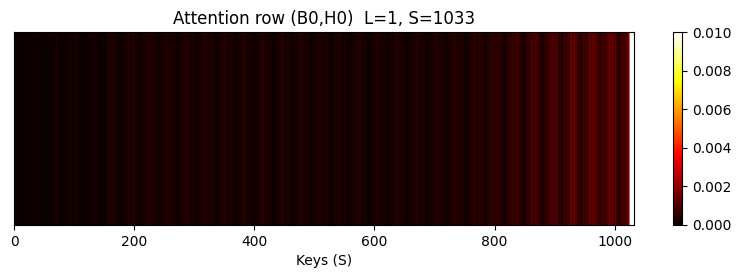

Plotting attention row map for token 1033 generation on layer 6


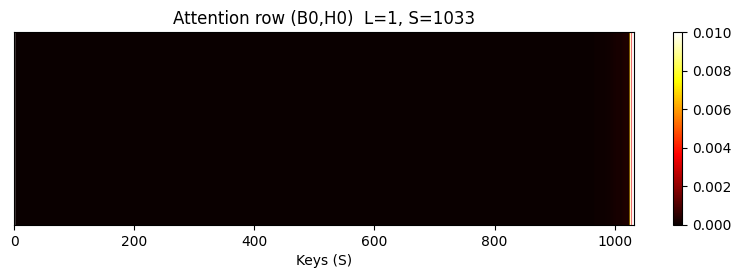

Plotting attention row map for token 1033 generation on layer 11


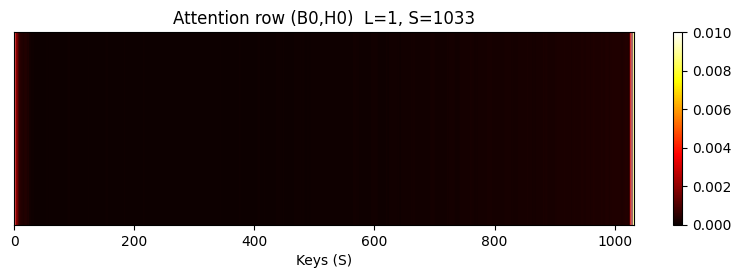


Example 0 / 3


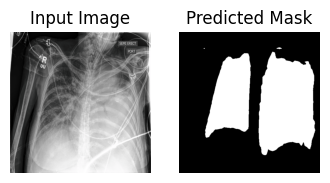

Segmentation mask per layer


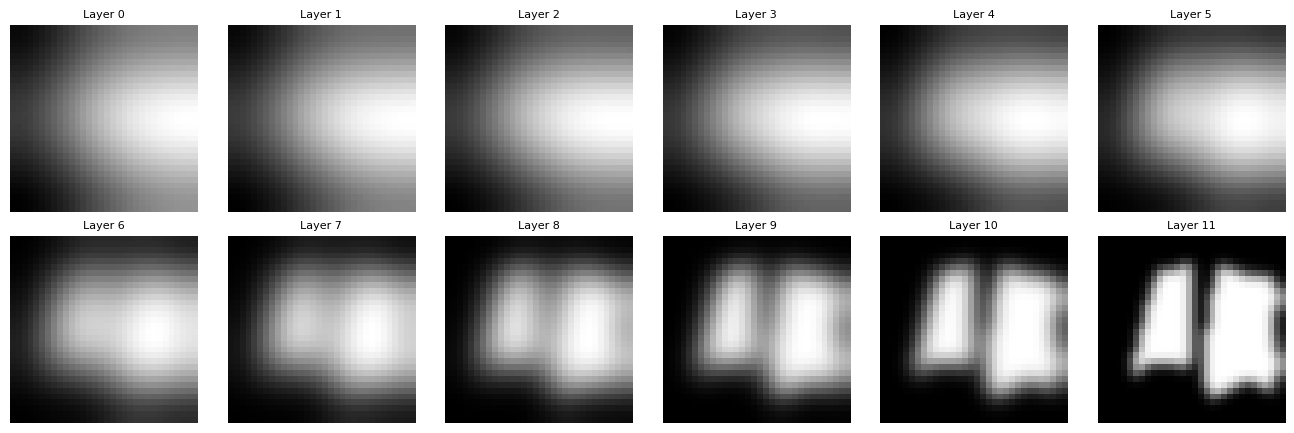

Generated text:  right ij line and endotracheal tube are in stable position. interval removal of the nasogastric tube with no evidence of pneumothorax or pleural effusion on this side. persistent left lower lobe opacity consistent with atelectasis versus consolidation unchanged from prior exam. redemonstration of diffuse reticular pattern throughout both lungs which may represent mild pulmonary edema however infection cannot be excluded as well. small bilateral apical opacities likely representing scarring but not significantly changed compared
Original Impression Text: slightly improved minimal aeration of the left lung. unchanged right pulmonary edema. physician to physician radiology consult line 4474643790 i have personally reviewed the images for this examination and agreed with the report transcribed above.

Example 1 / 3


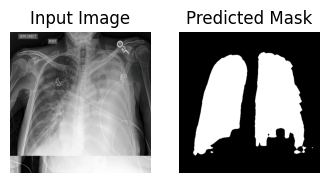

Segmentation mask per layer


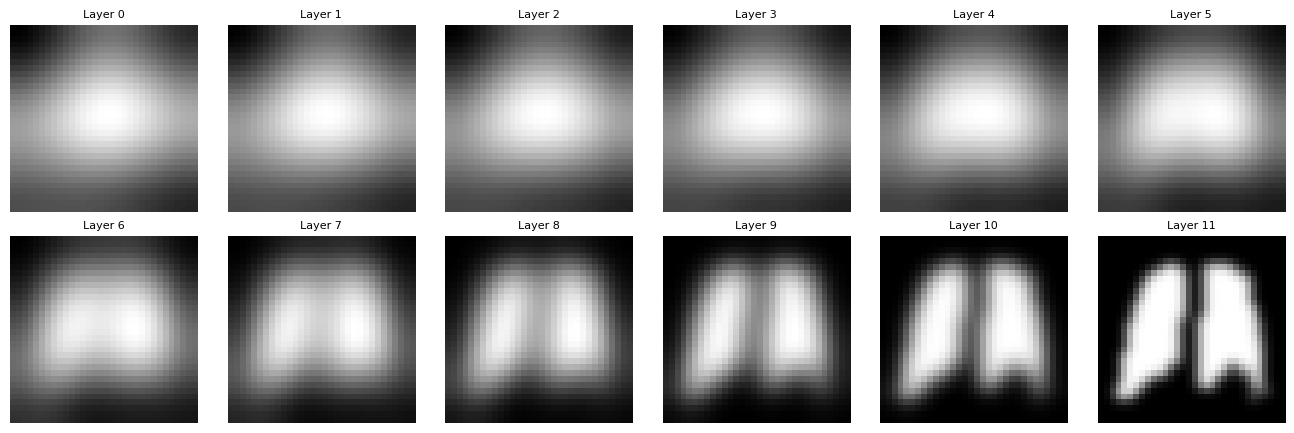

Generated text:  support equipment lines and tubes are unchanged. persistent left lower lobe atelectasis or consolidation with associated small right pleural effusion which may represent a component of aspiration versus infection however this is not entirely excluded from the examination. stable cardiomegaly without evidence of pneumothorax status post sternotomy changes in place as well as bilateral chest wall subcutaneous emphysema consistent with prior history of pulmonary edema no significant interval change compared to previous exam dated 8122008 i have personally
Original Impression Text: interval increase in the size of the left pleural effusion which now covers almost the entire hemithorax. i have personally reviewed the images for this examination and agreed with the report transcribed above.

Example 2 / 3


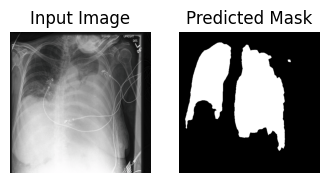

Segmentation mask per layer


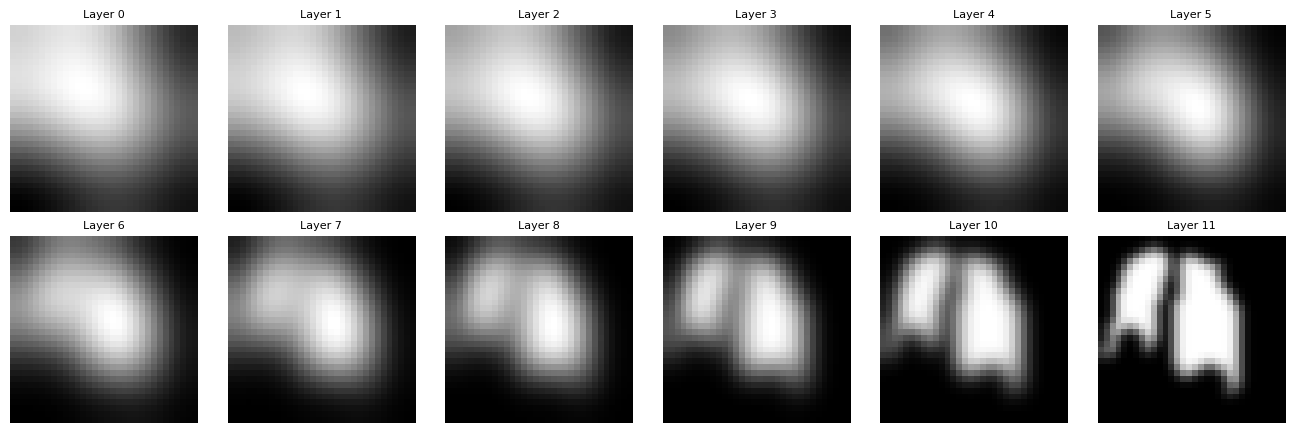

Generated text:  endotracheal tube nasogastric tubes and feeding tube are all in stable position. interval removal of the right internal jugular central venous catheter with its tip now at the cavoatrial junction which is not well visualized on this study but may be within the proximal superior vena cava. no evidence of pneumothorax or pleural effusion as clinically queried. persistent low lung volumes bibasilar opacities left greater than right unchanged from prior examination
Original Impression Text: large left pleural effusion increased from prior physician to physician radiology consult line 447 4643790

Example 3 / 3


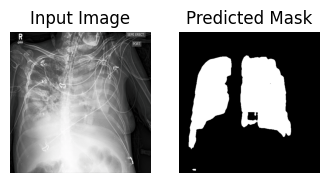

Segmentation mask per layer


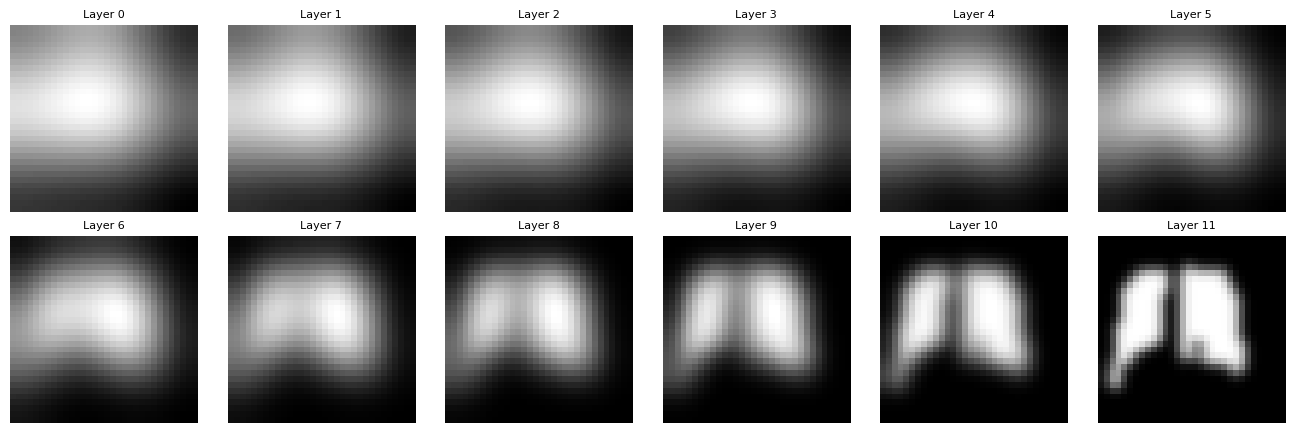

Generated text:  and endotracheal tube nasogastric tubes right internal jugular line left subclavian central venous catheter feeding tube ng tube swanganz catheter in place. interval removal of the previously seen rightsided chest drain with no evidence of pneumothorax or pleural effusion on this film. stable cardiomegaly without significant change from prior examination. redemonstration of diffuse reticular pattern throughout both lungs which may represent mild pulmonary edema versus infection as well
Original Impression Text: left hemithorax complete opacification likely due to further enlarged large pleural effusion with complete left lung collapse. unchanged right right pleural effusion with right basilar opacity suggestive of compressive atelectasis. physician to physician radiology consult line 379 6020819 i have personally reviewed the images for this examination and agreed with the report transcribed above.


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt

# -------------------
# Config / Utilities
# -------------------
vis_dim = 384
lr = 5e-5
weight_decay = 0.01
epochs = 1          # increase for real training
grad_clip = 1.0
BASE_KSIZE = 3
KSIZE_GROW = 4
SIGMA = None        # your heuristic

# Ensure tokenizer has PAD (we won't create attention masks, but we'll mask pads in labels)
if getattr(tokenizer, "pad_token", None) is None:
    tokenizer.pad_token = tokenizer.eos_token
pad_id = tokenizer.pad_token_id

# -------------------
# Trainables / Freeze
# -------------------
linear_projection = nn.Linear(vis_dim, decoder.config.n_embd).to(DEVICE)

# Freeze encoder & segmentator
encoder.eval().to("cpu")
for p in encoder.parameters():
    p.requires_grad = False

segmentator.eval().to("cpu")
for p in segmentator.parameters():
    p.requires_grad = False

# Train only linear_projection + decoder
decoder.train()
for p in decoder.parameters():
    p.requires_grad = True
for p in linear_projection.parameters():
    p.requires_grad = True

optim = AdamW(
    list(linear_projection.parameters()) + list(decoder.parameters()),
    lr=lr, weight_decay=weight_decay
)

# -------------------
# Batch builder (NO attention mask)
# -------------------
def build_batch(pixel_values: torch.Tensor,
                tgt_ids: torch.Tensor):
    """
    Returns:
      inputs_embeds: [B, Np+T, n_embd]
      labels:        [B, Np+T] with prefix=-100 and pads in text also -100
      segmask_tiled: tiled segmentation guidance (device=DEVICE)
    """
    B = pixel_values.size(0)

    # --- Segmentation (frozen) ---
    with torch.no_grad():
        pred = segmentator(pixel_values)  # [B,1,H,W] logits
        pred = F.interpolate(pred, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False)
        pred_sig = torch.sigmoid(pred).cpu().numpy()
        masks = (pred_sig[:, 0] > 0.5).astype(np.uint8) * 255  # [B,H,W] uint8

        n_layers = decoder.config.num_hidden_layers
        _, _, tiled = pipeline(torch.tensor(masks), n_layers, BASE_KSIZE, KSIZE_GROW, SIGMA)
        segmask_tiled = tiled.to(DEVICE)

    # --- Visual prefix (encoder frozen; projection trainable) ---
    with torch.no_grad():
        _, patches = encoder(pixel_values)         # [B,Np,vis_dim]
    prefix = linear_projection(patches.to(DEVICE))            # [B,Np,n_embd]

    # --- Text embeddings from GPT-2 table ---
    tgt_ids = tgt_ids.to(DEVICE)                   # [B,T]
    text_embeds = decoder.transformer.wte(tgt_ids) # [B,T,n_embd]

    # Concatenate prefix + text
    inputs_embeds = torch.cat([prefix, text_embeds], dim=1)  # [B,Np+T,n_embd]

    # Labels: ignore prefix with -100; mask PADs in text with -100 (no attention mask used)
    labels_prefix = torch.full((B, prefix.size(1)), -100, device=DEVICE, dtype=torch.long)
    text_labels = tgt_ids.clone()
    text_labels[text_labels == pad_id] = -100
    labels = torch.cat([labels_prefix, text_labels], dim=1)  # [B,Np+T]

    return inputs_embeds, labels, segmask_tiled

# ---------------
# Training loop
# ---------------
for ep in range(epochs):
    running = 0.0
    for step, (pixel_values, target_ids, paths, raw_labels) in enumerate(train_loader):
        if step >= 2000:  # limit steps for demo; remove for real training
            break
        pixel_values = pixel_values.to("cpu")

        inputs_embeds, labels, segmask_tiled = build_batch(pixel_values, target_ids)

        out = decoder(
            inputs_embeds=inputs_embeds,
            labels=labels,                    # GPT-2 handles shift internally
            segmentation_mask=segmask_tiled,  # your custom guidance
        )
        loss = out.loss

        optim.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(list(decoder.parameters()) + list(linear_projection.parameters()), grad_clip)
        optim.step()

        running += float(loss.detach().item())
        if (step + 1) % 50 == 0:
            print(f"[epoch {ep+1}] step {step+1}: loss {running / (step+1):.4f}")
        if (step + 1) in [200, 1000, 2000]:
            print("Saving decoder and linear projection model checkpoint...")
            torch.save(linear_projection.state_dict(), f"Datasets/CheXpertPlus/linear_projection{step+1}.pth")
            torch.save(decoder.state_dict(), f"Datasets/CheXpertPlus/decoder{step+1}.pth")

        del pixel_values, inputs_embeds, labels, segmask_tiled, out, loss
        torch.cuda.empty_cache()

    print(f"Epoch {ep+1} avg loss: {running / (step+1):.4f}")

# -----------------------
# One-batch TEST (GEN)
# -----------------------
decoder.eval()
linear_projection.eval()

with torch.no_grad():
    pixel_values, target_ids, paths, raw_labels = next(iter(test_loader))
    pixel_values = pixel_values.to("cpu")

    # Prepare segmentation guidance for viz + generation
    pred = segmentator(pixel_values)
    pred = F.interpolate(pred, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False)
    pred_sig = torch.sigmoid(pred).cpu().numpy()
    masks = (pred_sig[:, 0] > 0.5).astype(np.uint8) * 255
    B = masks.shape[0]

    n_layers = decoder.config.num_hidden_layers
    stacked, flat, tiled = pipeline(torch.tensor(masks), n_layers, BASE_KSIZE, KSIZE_GROW, SIGMA)
    print("stacked:", stacked.shape)  # (B,12,32,32) example
    print("flat:   ", flat.shape)     # (B,12,1024)
    print("tiled:  ", tiled.shape)    # (B,12,1024,1024)

    # Visual prefix embeddings only
    _, patches = encoder(pixel_values)
    patches = linear_projection(patches.to(DEVICE))  # [B,Np,n_embd]

    # Generate starting from visual prefix; NO attention mask
    gen_ids = decoder.generate(
        inputs_embeds=patches,
        max_new_tokens=100,
        do_sample=False,
        repetition_penalty=1.2,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        segmentation_mask=tiled.to(DEVICE),
        prefix_allowed_length=0,
        plot_attention_mask=False,
        plot_attention_mask_layer=[0, 6],
        plot_attention_map=True,
        plot_attention_map_layer=[0, 6, 11],
        plot_attention_map_generation=1024+10-1,
    )
    texts = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)

    # ---- Simple visualization / logging per sample ----
    for b in range(B):
        print(f"\nExample {b} / {B-1}")
        plt.figure(figsize=(4, 2))
        plt.subplot(1, 2, 1)
        plt.title("Input Image")
        plt.imshow(denormalize(pixel_values[b]).permute(1, 2, 0).cpu().numpy().astype(np.uint8))
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Predicted Mask")
        plt.imshow(masks[b], cmap="gray")
        plt.axis("off")
        plt.show()

        print("Segmentation mask per layer")
        plot_stacked_layers(stacked, sample_idx=b, cols=6)
        plt.show()

        print("Generated text:", texts[b])
        print("Original Impression Text:", raw_labels[b])


In [7]:
print("Segmentator parameters to train:", sum(p.requires_grad for p in segmentator.parameters()))
print("Encoder parameters to train:", sum(p.requires_grad for p in encoder.parameters()))
print("Linear projection parameters to train:", sum(p.requires_grad for p in linear_projection.parameters()))
print("Total linear projection parameters:", sum(p.numel() for p in linear_projection.parameters() if p.requires_grad))
print("Decoder parameters to train:", sum(p.requires_grad for p in decoder.parameters()))
print("Total decoder parameters:", sum(p.numel() for p in decoder.parameters() if p.requires_grad))
print("Total trainable parameters:", 
      sum(p.numel() for p in segmentator.parameters() if p.requires_grad) +
      sum(p.numel() for p in encoder.parameters() if p.requires_grad) +
      sum(p.numel() for p in linear_projection.parameters() if p.requires_grad) +
      sum(p.numel() for p in decoder.parameters() if p.requires_grad)
     )

Segmentator parameters to train: 0
Encoder parameters to train: 0
Linear projection parameters to train: 2
Total linear projection parameters: 295680
Decoder parameters to train: 148
Total decoder parameters: 125226240
Total trainable parameters: 125521920


In [19]:
from utils.text_metrics import evaluate_all_metrics, save_metrics_to_json

epochs = [10, 50, 100]
model_names = ['200', '1000', '2000']
training_time = [68, 343, 686]
# for i, model in enumerate(model_names):
for i, model_name in enumerate(model_names):
    decoder_path = f"Datasets/CheXpertPlus/decoder{model_name}.pth"
    linear_projection_path = f"Datasets/CheXpertPlus/linear_projection{model_name}.pth"
    decoder.load_state_dict(torch.load(decoder_path, map_location=DEVICE))
    linear_projection.load_state_dict(torch.load(linear_projection_path, map_location=DEVICE))

    generated_text = []
    target_text = []
    iteration = 0
    test_loader = DataLoader(ds_test, batch_size=NUM_BATCH, shuffle=False, collate_fn=collate_fn)
    with torch.no_grad():
        for pixel_values, ids_loader, paths, raw_labels in test_loader:
            iteration += 1
            pixel_values = pixel_values.to("cpu")

            # Prepare segmentation guidance for viz + generation
            pred = segmentator(pixel_values)
            pred = F.interpolate(pred, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False)
            pred_sig = torch.sigmoid(pred).cpu().numpy()
            masks = (pred_sig[:, 0] > 0.5).astype(np.uint8) * 255
            B = masks.shape[0]

            n_layers = decoder.config.num_hidden_layers
            stacked, flat, tiled = pipeline(torch.tensor(masks), n_layers, BASE_KSIZE, KSIZE_GROW, SIGMA)

            # Visual prefix embeddings only
            _, patches = encoder(pixel_values)
            patches = linear_projection(patches.to(DEVICE))  # [B,Np,n_embd]

            # Generate starting from visual prefix; NO attention mask
            gen_ids = decoder.generate(
                inputs_embeds=patches,
                max_new_tokens=100,
                do_sample=False,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.pad_token_id,
                segmentation_mask=tiled.to(DEVICE),
                prefix_allowed_length=0,
                plot_attention_mask=False,
                plot_attention_mask_layer=[0, 6],
                plot_attention_map=False,
                plot_attention_map_layer=[0, 6, 11],
                plot_attention_map_generation=1024+10-1,
            )
            texts = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)

            eval_results = evaluate_all_metrics(generated=texts, original=raw_labels, evaluation_mode="CheXagent")
            # print(f"\nResults for model trained {epochs[i]} epochs, batch {iteration}:")
            # for metric, scores in eval_results.items():
            #     print(f"{metric}: {scores}")
            generated_text.extend(texts)
            target_text.extend(raw_labels)

            if iteration >= 200:  # Limit to 200 iterations for testing
                break
    eval_results = evaluate_all_metrics(generated=generated_text, original=target_text, evaluation_mode="CheXagent")
    print(f"\nOverall results for model trained {epochs[i]} epochs:")
    for metric, scores in eval_results.items():
        print(f"{metric}: {scores}")

    eval_results["training_time_seconds"] = training_time[i]
    save_metrics_to_json(eval_results, f"lstm-vs-gpt/results/gpt2_modified_model_results_{epochs[i]}_Chexpert.json")

Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device: cuda:0
Using device:

In [12]:

text = "Original Impression Text: left hemithorax complete opacification likely due to further enlarged large pleural effusion with complete left lung collapse. unchanged right right pleural effusion with right basilar opacity suggestive of compressive atelectasis. physician to physician radiology consult line 379 6020819 i have personally reviewed the images for this examination and agreed with the report transcribed above."
import re
# Extract everything before "physician to physician"
cutoff = "physician to physician"
before = text.split(cutoff)[0].strip()

print(before)

Original Impression Text: left hemithorax complete opacification likely due to further enlarged large pleural effusion with complete left lung collapse. unchanged right right pleural effusion with right basilar opacity suggestive of compressive atelectasis.
